In [ ]:
from google.colab import drive
drive.mount("./drive", force_remount=True)

path_prefix = "./drive/My Drive"

Mounted at ./drive


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

%matplotlib inline

In [ ]:
filename = "fraud_data.csv"
df = pd.read_csv(join(path_prefix, filename), index_col=0)

df.head()


,transaction_id,day,amount,card,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,label
0,861163,11,4.14,2105835,-430.764171,-320.015845,-126.521888,62.573045,101.190832,-19.647190,-13.328663,3.536347,-12.885088,1.575640,-0.879015,-1.013924,-2.195600,-0.335761,-0.566656,0.133997,-0.112530,0.133236,0.061701,-0.040570,-0.131249,-0.016216,0.001330,-0.000022,False
1,481857,7,102.58,3595939,-435.431389,-322.187188,-13.951082,-6.550536,-119.609051,4.658029,-3.273450,3.490142,9.482249,17.858529,-0.554083,0.126893,-0.220055,0.022814,-0.103251,-0.788776,0.332418,0.997110,-0.172463,0.032128,-0.073120,-0.000139,-0.002084,-0.000290,False
2,1215246,16,116.98,5953735,-434.424026,-330.553462,-18.809262,41.065894,74.053132,107.341293,-10.219304,3.182406,2.985591,-0.833696,-0.149106,0.001384,-0.605515,-0.194779,0.436881,-1.341081,0.527236,-1.071288,0.207154,0.059550,1.247738,-0.217314,0.075597,-0.000344,False
3,793548,11,59.90,1298385,-442.129375,632.447065,330.925334,-264.756853,-6.839567,48.566958,4.905629,-15.643984,-4.170122,-0.928957,-1.944994,1.173714,0.142302,-1.038035,1.041172,0.816854,-0.418644,0.152984,0.253243,0.006046,-0.016408,-0.004193,-0.020025,0.000004,False
4,4307,1,138.00,5029495,-405.270687,-303.103313,-253.927088,-38.299339,-117.636587,-8.799181,-2.525076,-16.500900,-12.269734,1.010618,0.759805,4.383355,0.442175,0.522420,-1.306245,0.954463,1.138813,-0.145031,0.701119,-0.997044,-0.077150,-0.008464,0.000779,0.000138,False


## Ratio Between Fraudalent and Non-Fraudalent Transactions 


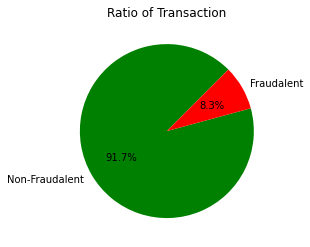

In [ ]:
from numpy.core.fromnumeric import size
a=0
b=0
c=0
for i in range (len(df['label'])):
  c=c+1
  if df['label'][i]==False:
    a=a+1
  elif df['label'][i]==True:
    b=b+1

f=a*100/c
g=b*100/c
y = np.array([f,g])
mylabels = ["Non-Fraudalent", "Fraudalent"]

plt.pie(y, labels = mylabels,autopct='%1.1f%%',colors=['green','red'],startangle=45)
plt.title('Ratio of Transaction')

plt.show() 


## Split the data into train (70%), validation (15%) and test (15%). 

In [ ]:
from sklearn.model_selection import train_test_split

df_oyna=df
X = df_oyna.drop(['transaction_id','card','label'], axis=1)
Y=df_oyna['label']
X_train, X_remaining,Y_train, Y_remaining= train_test_split(X,Y, test_size=0.30, random_state=0,stratify=df_oyna['label'])
X_test, X_val,Y_test, Y_val = train_test_split(X_remaining,Y_remaining, test_size=0.50, random_state=0)

## Train a Default Random Forest Model (Baseline)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import class_weight
model = RandomForestClassifier(class_weight={0: g/10, 1: f/10})
    


## Evaluate the Baseline Model 

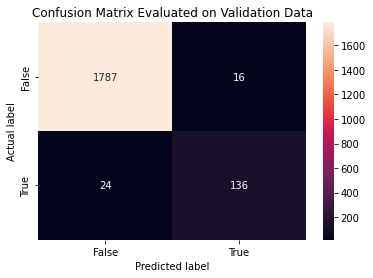

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
model.fit(X_train, Y_train)
x_pred=model.predict(X_val)
data = {'y_Actual':    Y_val,
        'y_Predicted': x_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual label'], colnames=['Predicted label'])

sn.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title('Confusion Matrix Evaluated on Validation Data')

plt.show()



### Plot ROC Curve Evaluated on Validation Data 

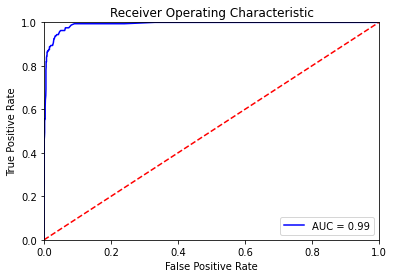

In [ ]:
from sklearn.metrics import RocCurveDisplay


import sklearn.metrics as metrics
probs = model.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



### Plot Precision-Recall Curve 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve')

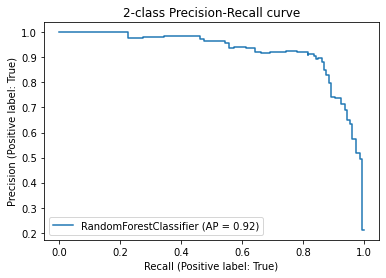

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve( model,X_val, Y_val)
disp.ax_.set_title('2-class Precision-Recall curve')

## Hyperparameter Tuning 

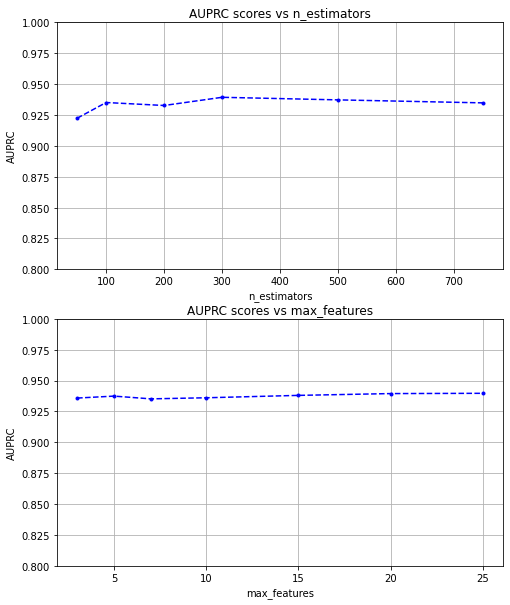

In [ ]:
from sklearn.metrics import auc, precision_recall_curve
n_estimator1= [50 ,100,200,300,500,750]
max_features= [3,5,7,10,15,20,25]
aucscore=[]
aucscore2=[]
for h in range (0,6):
  model2 = RandomForestClassifier(n_estimators=n_estimator1[h])
  model2.fit(X_train, Y_train)
  y_score = model2.predict_proba(X_val)[:, 1]
  precision, recall, thresholds = precision_recall_curve(Y_val, y_score)
  auc_precision_recall = auc(recall, precision)
  aucscore.append(auc_precision_recall)


plt.show
highs=0

for t in range (len(aucscore)):
  if aucscore[t]>highs:
    highs=aucscore[t]
    yer=t

for g in range (0,7):
  model2_1 = RandomForestClassifier(max_features=max_features[g],n_estimators=n_estimator1[yer])
  model2_1.fit(X_train, Y_train)
  y_score = model2_1.predict_proba(X_val)[:, 1]
  precision, recall, thresholds = precision_recall_curve(Y_val, y_score)
  auc_precision_recall = auc(recall, precision)
  aucscore2.append(auc_precision_recall)


plt.figure(1, figsize=(8, 10))

plt.subplot(211)
plt.plot(n_estimator1, aucscore, color='blue', linestyle='--', label='data',marker='.')
plt.title("AUPRC scores vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUPRC")

plt.ylim(0.8, 1)
plt.grid(axis='both')
plt.subplot(212)
plt.plot(max_features, aucscore2, color='blue', linestyle='--',marker='.', label='data')

plt.ylim(0.8, 1)
plt.title("AUPRC scores vs max_features")
plt.xlabel("max_features")
plt.ylabel("AUPRC")
plt.grid(axis='both')
plt.show()
  

## Retrain the Model with the Best Parameters

In [ ]:
highs2=0
for e in range (len(aucscore2)):
  if aucscore2[e]>highs2:
    highs2=aucscore2[e]
    yer2=e
model3 = RandomForestClassifier(max_features=max_features[yer2],n_estimators=n_estimator1[yer])
model3.fit(X_test, Y_test)
y_combined_predic = model3.predict(X_remaining)

## Evaluate the Final Model using Test data

### Plot Confusion Matrix (10 Points)

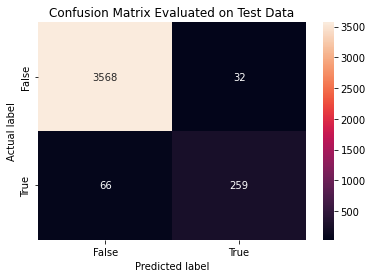

In [ ]:

y_combined_predic = model3.predict(X_remaining)


data = {'y_Actual':    Y_remaining,
        'y_Predicted': y_combined_predic
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual label'], colnames=['Predicted label'])

sn.heatmap(confusion_matrix, annot=True,fmt="d")
plt.title('Confusion Matrix Evaluated on Test Data')

plt.show()


### Plot ROC Curve Evaluated on Test Data 

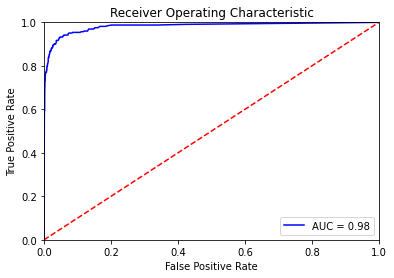

In [ ]:
probs = model3.predict_proba(X_remaining)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_remaining, preds)
roc_auc = metrics.auc(fpr, tpr)



plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



### Plot Precision-Recall Curve 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve')

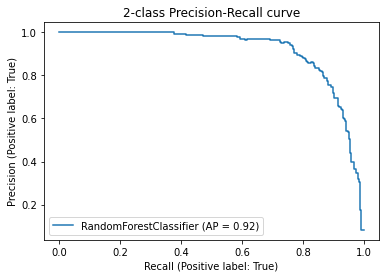

In [ ]:
disp = plot_precision_recall_curve( model3,X_remaining, Y_remaining)
disp.ax_.set_title('2-class Precision-Recall curve')